## Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np # Dizi ve matris işlemleri için özelleşmiş bir kütüphanedir.
import matplotlib.pyplot as plt #Grafikleştirme işlemleri için kullanılan kütüphanedir.
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#Eğitim öncesi görüntü ayarlarını yapmak için kullanılır.
#Görüntü artırma, ölçeklendirme gibi işlemler.

In [2]:
import glob, os#dosya işlemleri için kullanılan kütüphanelerdir.
import random 

## Verisetinin yüklenmesi

In [3]:
#Dosya yolu
base_path = r"C:\Users\Turan\Desktop\DerinOgrenme\TezCalismalari\veriseti\Garbage classification\garbage classification\Garbage classification"
#dosyadan okunan fotoğrafların yüklendiği değişken
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


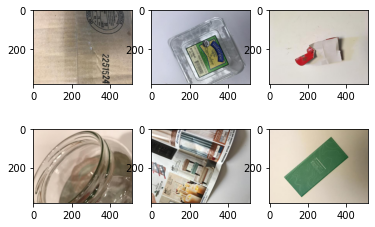

In [4]:
#Verisetinden örnek bir kaç görüntü
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

## Veri setinin modelin girişine hazırlanması ve bölünmesi

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,#Ölçeklendirme, verilen değerle çarpılır.
    shear_range=0.1,#Kesme açısı
    zoom_range=0.1,#Rastgele yaklaştırma
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,#Girilen değeri rastgele yatay çevirme.
    vertical_flip=True,#Girilen değeri rastgele dikey çevirme.
    validation_split=0.1#Doğrulama için ayrılan val'ın oranı
)

test_datagen = ImageDataGenerator(
    rescale=1./255,#ölçeklendirme
    validation_split=0.1#Doğrulama için ayrılan val'ın oranı
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(254, 254),#Fotoğrafın kaça kaç olacağı
    #batch_size=50,#Veri yığınlarının boyutu. 
    class_mode='categorical',#Sınıfların sırasını kontrol etmek için kullanılır
    subset='training',#Alt küme ayarlama validation/training
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(254, 254),#Fotoğrafın kaça kaç olacağı
    # batch_size=50,#Veri yığınlarının boyutu.
    class_mode='categorical',#Veri yığınlarının boyutu.
    subset='validation',#Alt küme ayarlama validation/training
    seed=0
)

#Etiketlerin gösterimi
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


## Derin öğrenme kütüphanelerinin yüklenmesi

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.regularizers import l1, l2, L1L2
from keras.callbacks import EarlyStopping, ModelCheckpoint



## VGG16 modelinin yüklenmesi

In [7]:
vgg = VGG16(
    weights = 'imagenet',#İmageNet'in ağırlıklarını yükler.
    include_top = False,
    input_shape = (254, 254, 3))#Görüntünün giriş boyutu

In [8]:
#Son üç katmanı öğrenmeye kapatır.
for layer in vgg.layers[:-3]:
    layer.trainable = False

## Yeni model oluşturma

In [9]:
model = Sequential()#Yeni model oluşturur.
 
model.add(vgg)#VGG modelini giriş olarak verir.(Functional)
 
model.add(Flatten())#Düzleştirme katmanı
model.add(Dense(1024, activation='relu'))#Tam bağlı katman
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))#Çıkış katmanı

In [10]:
model.summary()#Model özeti

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 30,416,902
Non-trainable params: 9,995,072
_________________________________________________________________


## Modeli derleme

In [11]:
model.compile(loss='categorical_crossentropy',#Kayıp fonksiyonu
              optimizer=Nadam(lr=1e-4),#Optimizasyon fonksiyonu
              metrics=['acc'])#Doğruluk ölçütü-değeri

In [12]:
batch_size = 32 #Bir seferde verilecek veri yığını boyutu
epochs = 100 #İterasyon sayısı

In [13]:
#bir iterasyonda verilecek train ve test verilerinin oranlanması
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

## Early Stopping ve Model Checkpoint

In [19]:
"""
from keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = "model_vgg16_garbage.h5"#Kaydedilecek modelin adı
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)#Aşırı öğrenmeyi önlemek için kullanılır.
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#Modelin test verisi üzerinde başarısı her arttığında kaydetme işlemini yapar.
callbacks_list = [es, checkpoint1]
"""
from keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = "model_vgg16_{epoch:02d}-{val_acc:.2f}.h5"#Kaydedilecek modelin adı
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)#Aşırı öğrenmeyi önlemek için kullanılır.
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#Modelin test verisi üzerinde başarısı her arttığında kaydetme işlemini yapar.
callbacks_list = [es, checkpoint1]#Eğitime verilmek için liste haline getirildi.

## Modelin Eğitilmesi

In [20]:
history = model.fit_generator(
    generator=train_generator, #Eğitim verisi
    epochs=epochs, #iterasyon sayısı
    steps_per_epoch=steps_per_epoch, 
    validation_data=validation_generator,#Test verisi
    validation_steps=validation_steps,
    callbacks=callbacks_list#Early stopping ve model checkpoint değerleri
)

Epoch 1/100
71/71 [==============================] - 38s 533ms/step - loss: 0.5908 - acc: 0.7870 - val_loss: 0.5202 - val_acc: 0.8125

Epoch 00001: val_acc improved from -inf to 0.81250, saving model to model_vgg16_01-0.81.h5
Epoch 2/100
71/71 [==============================] - 35s 495ms/step - loss: 0.4756 - acc: 0.8204 - val_loss: 0.6797 - val_acc: 0.7679

Epoch 00002: val_acc did not improve from 0.81250
Epoch 3/100
71/71 [==============================] - 36s 498ms/step - loss: 0.3987 - acc: 0.8561 - val_loss: 0.6317 - val_acc: 0.7812

Epoch 00003: val_acc did not improve from 0.81250
Epoch 4/100
71/71 [==============================] - 39s 550ms/step - loss: 0.3288 - acc: 0.8743 - val_loss: 0.6846 - val_acc: 0.7723

Epoch 00004: val_acc did not improve from 0.81250
Epoch 5/100
71/71 [==============================] - 35s 487ms/step - loss: 0.2783 - acc: 0.9029 - val_loss: 0.6499 - val_acc: 0.8080

Epoch 00005: val_acc did not improve from 0.81250
Epoch 6/100
71/71 [===============

## Sonuç skoru

In [21]:
score = model.evaluate(validation_generator,batch_size=32)
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

8/8 [==============================] - 13s 2s/step - loss: 0.7870 - acc: 0.8566
Score Accuracy : 85.66%


## Sonuçların görselleştirilmesi

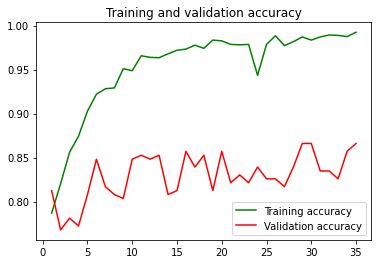

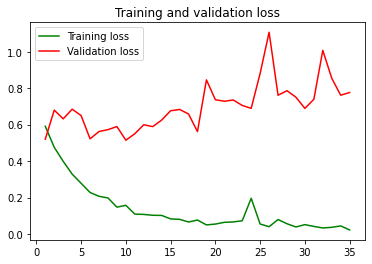

In [22]:
#Eğitim sürecinin görselleştirilmesi

import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'g', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()